# **Transformer** **Architecture**





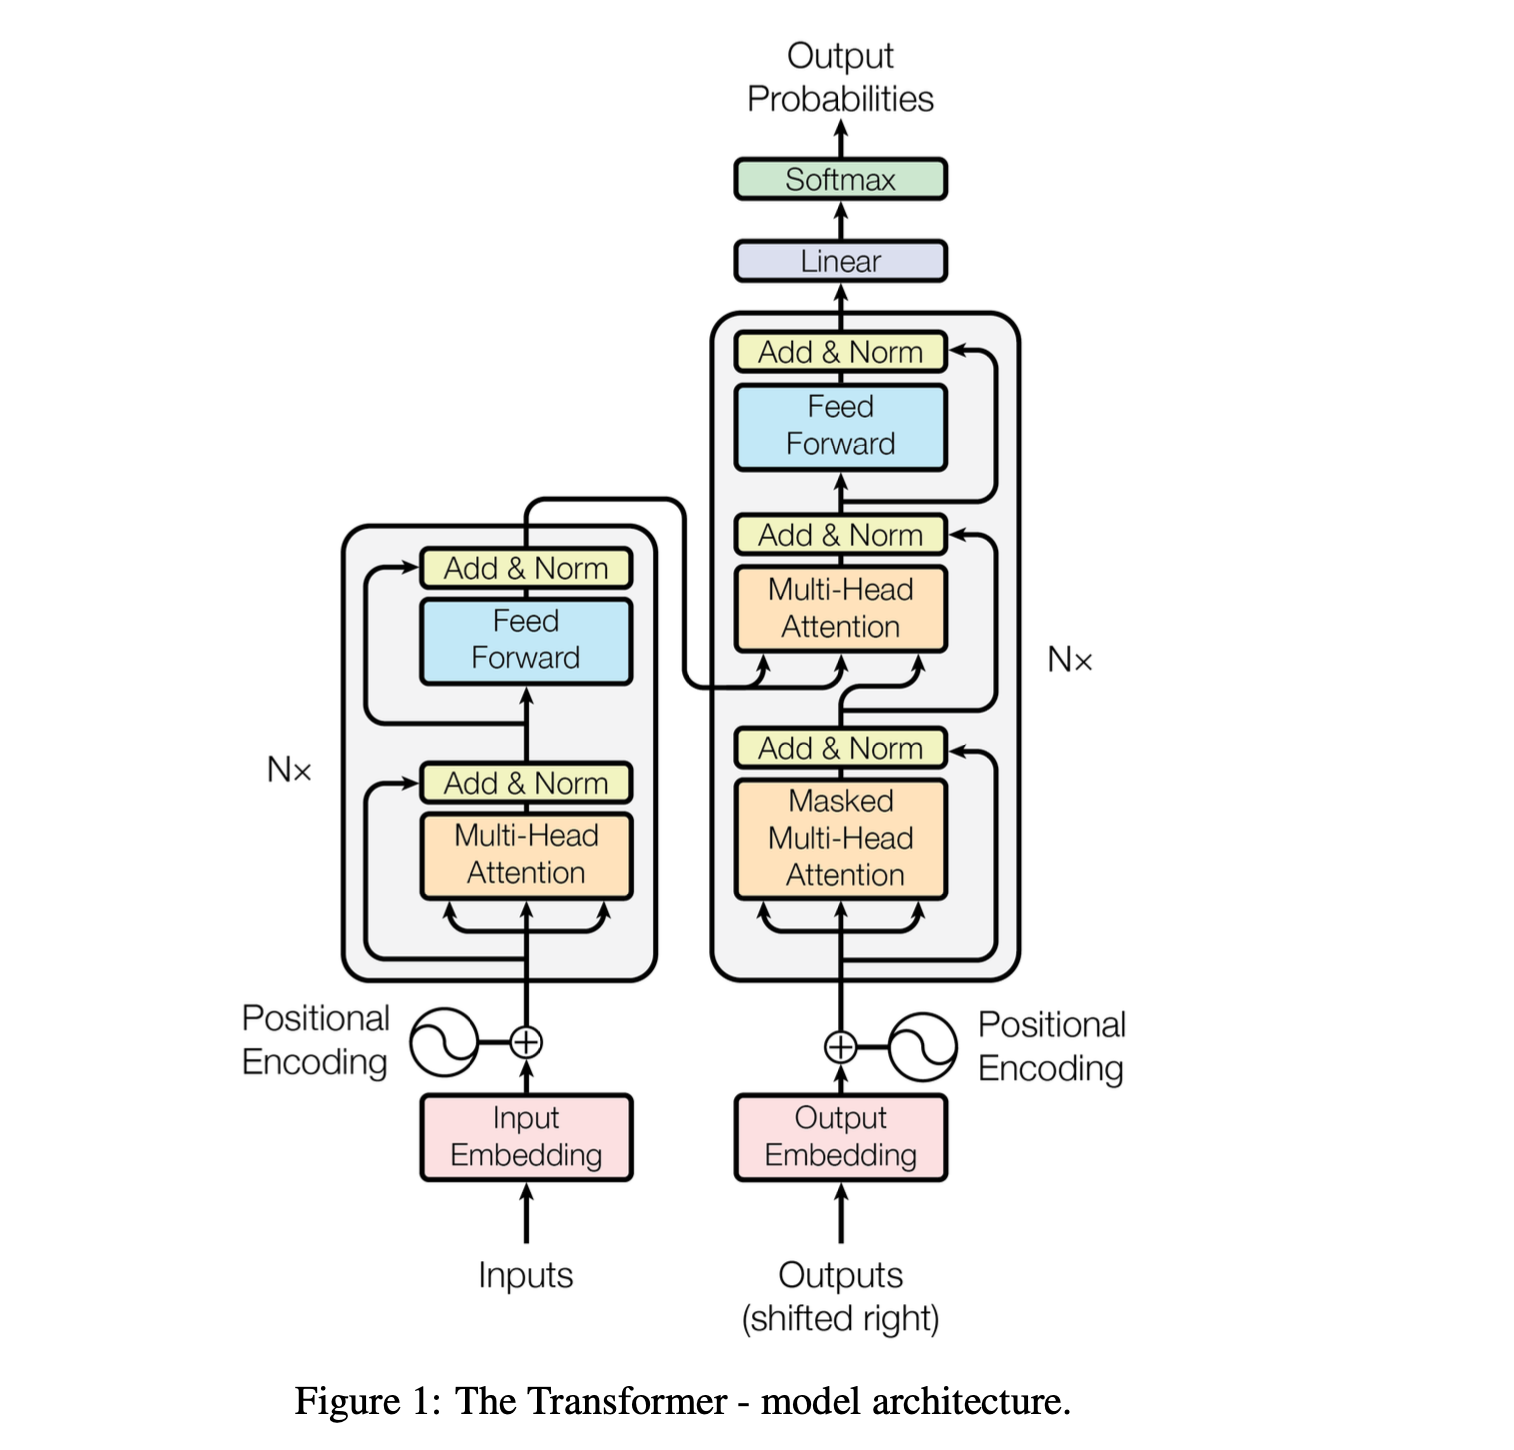

# **Workflow**

0. Import Liabraries
1. Input Embedding
2. Positional Encoding
3. MultiHead Attention (Self Attention)
4. add and norm (Layer Normalization)
5. Feed Forward Network
6. Residual Connection
7. Encoder
8. Decoder
9. Building a Transformer
10. Test our Transformer
11. Tokenizer
12. Loading Dataset
13. Validation Loop
14. Training Loop
15. Conclusion

# **Importing Liabraries**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader , random_split
from torch.utils.tensorboard import SummaryWriter

# Math
import math

# HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Pathlib
from pathlib import Path

# Typing
from typing import Any

# Libraries for progress bars in loops
from tqdm import tqdm

# Importing liabrary of warnings
import warnings

#  **Input Embedding**

d_model = 512

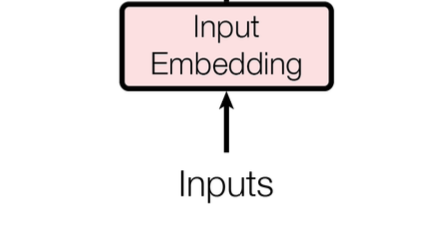

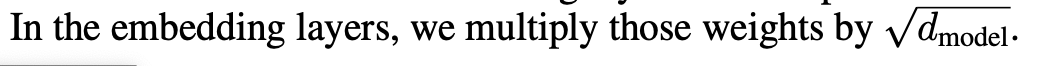

# English Sentence
The animal didn't cross the street beacuse it was too tired

In [52]:
class InputEmbeddings(nn.Module):

  def __init__(self , d_model:int , vocab_size:int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size , d_model)

  def forward(self , x):
    return self.embedding(x) * math.sqrt(self.d_model)

In [53]:
d_model = 512
vocab_size = 10

# **Positional** **Encoding**

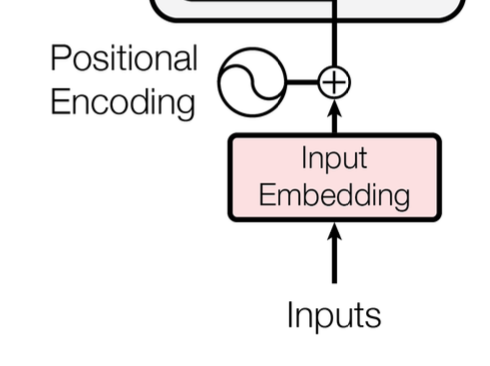

The positional encodings have the same dimension d_model as the embeddings

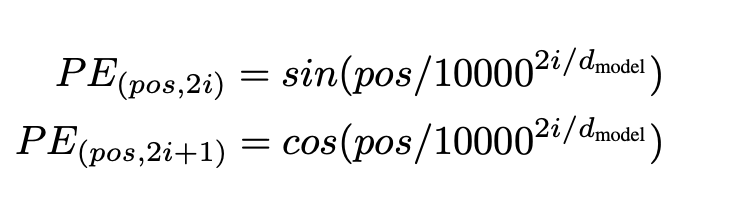

In [54]:
class PositionalEncoding(nn.Module):

  def __init__(self , d_model:int , seq_len:int , dropout:float = 0.1):
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    pe = torch.zeros(seq_len , d_model)
    position = torch.arange(0 , seq_len , dtype = torch.float).unsqueeze(1) # [seq_len , 1]

    div_term = torch.exp(torch.arange(0 , d_model , 2).float() * (-math.log(10000.0) / d_model))

    pe[: , 0::2] = torch.sin(position * div_term)
    pe[: , 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)

    self.register_buffer('pe' , pe)

  def forward(self , x):
    x = x + self.pe[:, :x.shape[1], :].detach()
    return x


# MultiHead Attention (Self Attention)




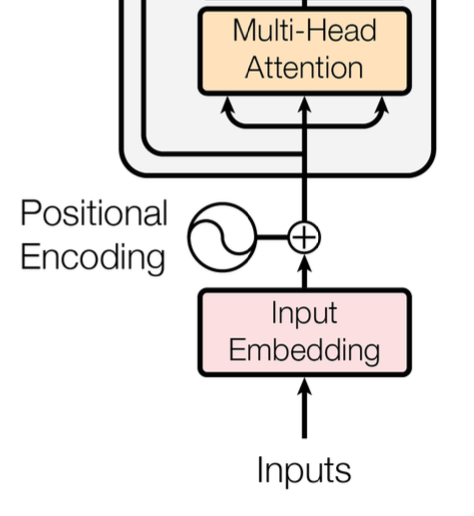

In [55]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self , d_model:int , h:int , dropout:float = 0.1) -> None:
    super().__init__()
    self.d_model = d_model
    self.h = h

    assert d_model % h == 0 , 'd_model is not divisible by h'
    self.d_k = d_model // h
    self.w_q = nn.Linear(d_model , d_model)
    self.w_k = nn.Linear(d_model , d_model)
    self.w_v = nn.Linear(d_model , d_model)
    self.w_o = nn.Linear(d_model , d_model)
    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def attention(query , key , value , mask , dropout:nn.Dropout):
    d_k = key.shape[-1]
    attention_score = (query @ key.transpose(-2 , -1)) / math.sqrt(d_k)

    if mask is not None:
      attention_score.masked_fill(mask==0 , -1e9)
    attention_score = attention_score.softmax(dim = -1)

    if dropout is not None:
      attention_score = dropout(attention_score)

    return (attention_score @ value) , attention_score
  

  def forward(self , q , k , v , mask):
    query = self.w_q(q)
    key = self.w_k(k)
    value = self.w_v(v)

    query = query.view(query.shape[0] , query.shape[1] , self.h , self.d_k).permute(0, 2, 1, 3)
    key = key.view(key.shape[0] , key.shape[1] , self.h , self.d_k).permute(0, 2, 1, 3)
    value = value.view(value.shape[0] , value.shape[1] , self.h , self.d_k).permute(0, 2, 1, 3)

    x , self.activation_score = MultiHeadAttentionBlock.attention(query , key , value , mask , self.dropout)
    x = x.transpose(1 , 2).contiguous().view(x.shape[0] , -1 , self.h * self.d_k)
    return self.w_o(x)

# Layer Normalization

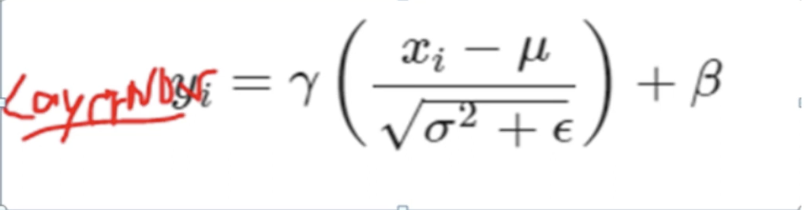

In [56]:
class LayerNormalization(nn.Module):
  def __init__(self , eps:float = 10**-6) -> None:
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1))
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self , x):
    mean = x.mean(dim = -1 , keepdim = True)
    std = x.std(dim = -1 , keepdim = True)

    return self.alpha * ((x - mean) / (std + self.eps)) + self.bias



# Feed Forward

**This consists of two linear transformations with a ReLU activation in between.**

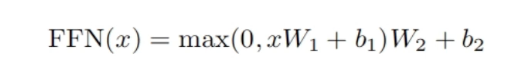

In [57]:
class FeedForwardBlock(nn.Module):
  def __init__(self , d_model:int , d_ff:int , dropout:float = 0.1):
    super().__init__()
    self.linear_1 = nn.Linear(d_model , d_ff)
    self.dropout = nn.Dropout(dropout)
    self.linear_2 = nn.Linear(d_ff , d_model)

  def forward(self , x):
    return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

# Residual Connection

In [58]:
class ResidualConnection(nn.Module):
  def __init__(self , dropout:float = 0.1) -> None:
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()

  def forward(self , x , sublayer):
   # return x + self.dropout(self.norm(sublayer(x)))
     return x + self.dropout(sublayer(self.norm(x)))


# Encoder

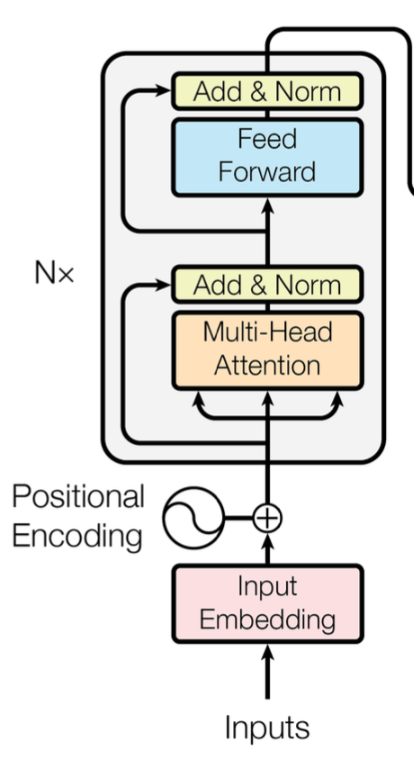

In [59]:
class EncoderBlock(nn.Module):
  def __init__(self , self_attention_block: MultiHeadAttentionBlock , feed_forward_block: FeedForwardBlock , dropout:float = 0.1) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    self.dropout = dropout

    self.residual_connections = nn.ModuleList(ResidualConnection(dropout) for _ in range(2))

  def forward(self , x , src_mask):
    x = self.residual_connections[0](x , lambda x: self.self_attention_block(x , x , x , src_mask))
    x = self.residual_connections[1](x , self.feed_forward_block)
    return x
  

In [60]:
class Encoder(nn.Module):
  def __init__(self , layers: nn.ModuleList , dropout:float = 0.1) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self , x , mask):
    for layer in self.layers:
      x = layer(x , mask)

    return self.norm(x)


# Decoder

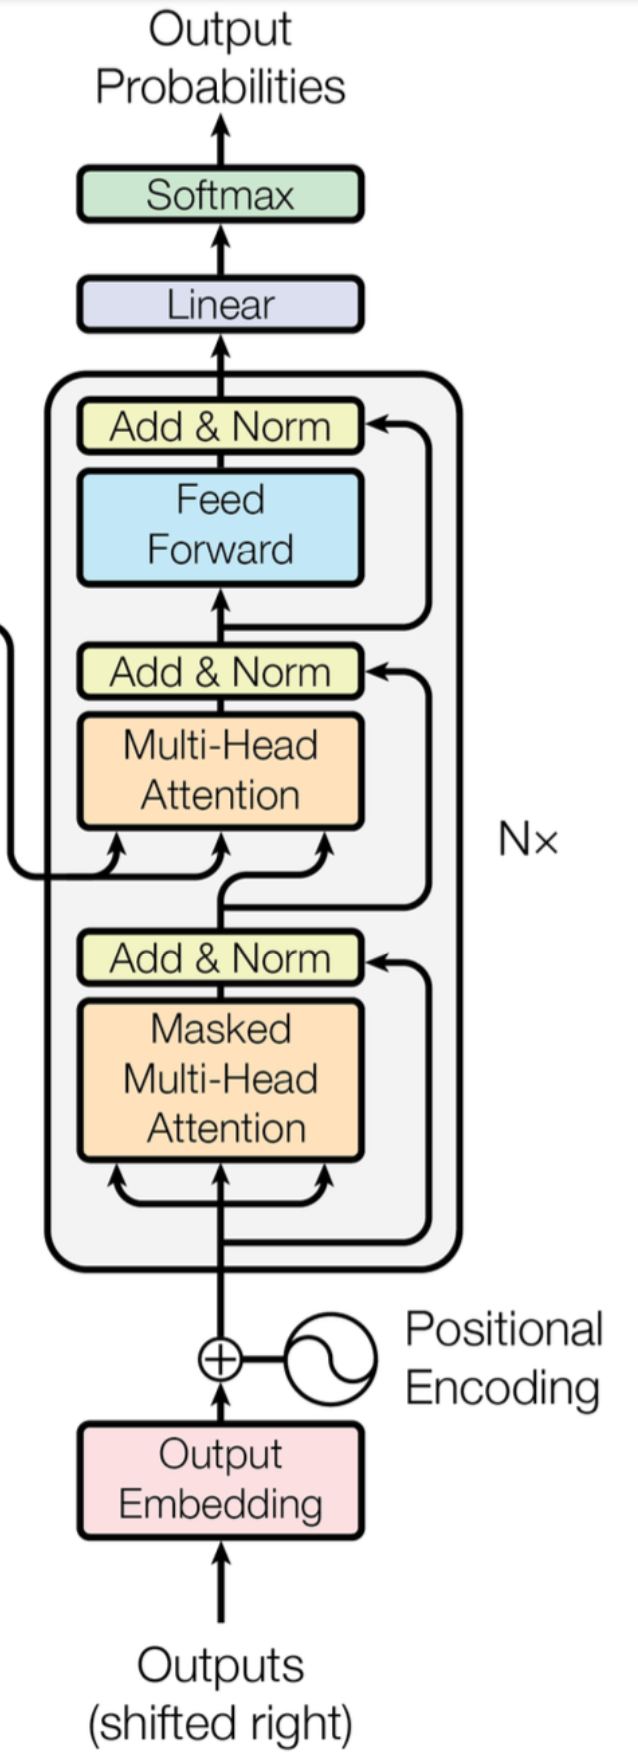

In [61]:
class DecoderBlock(nn.Module):
  def __init__(self , self_attention_block:MultiHeadAttentionBlock , cross_attention_block: MultiHeadAttentionBlock , feed_forward_block:FeedForwardBlock , dropout:float = 0.1) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])
    self.dropout = nn.Dropout(dropout)

  def forward(self , x , encoder_output , src_mask , tgt_mask):
    x = self.residual_connections[0](x , lambda x : self.self_attention_block(x , x , x , tgt_mask))
    x = self.residual_connections[1](x , lambda x : self.cross_attention_block(x , encoder_output , encoder_output , src_mask))
    x = self.residual_connections[2](x , lambda x : self.feed_forward_block(x))

    return x



In [62]:
class Decoder(nn.Module):
  def __init__(self , layers:nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self , x , encoder_output , src_mask , tgt_mask):
    for layer in self.layers:
      x = layer(x , encoder_output , src_mask , tgt_mask)

    return self.norm(x)


# Linear Layer

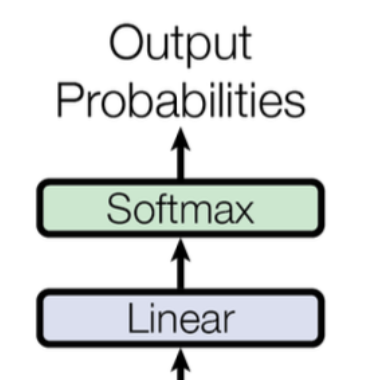

In [63]:
class ProjectionLayer(nn.Module):
  def __init__(self , d_model:int , vocab_size:int) -> None:
    super().__init__()
    self.linear = nn.Linear(d_model , vocab_size)

  def forward(self , x):
    return torch.log_softmax(self.linear(x) , dim = -1)

# Transformer

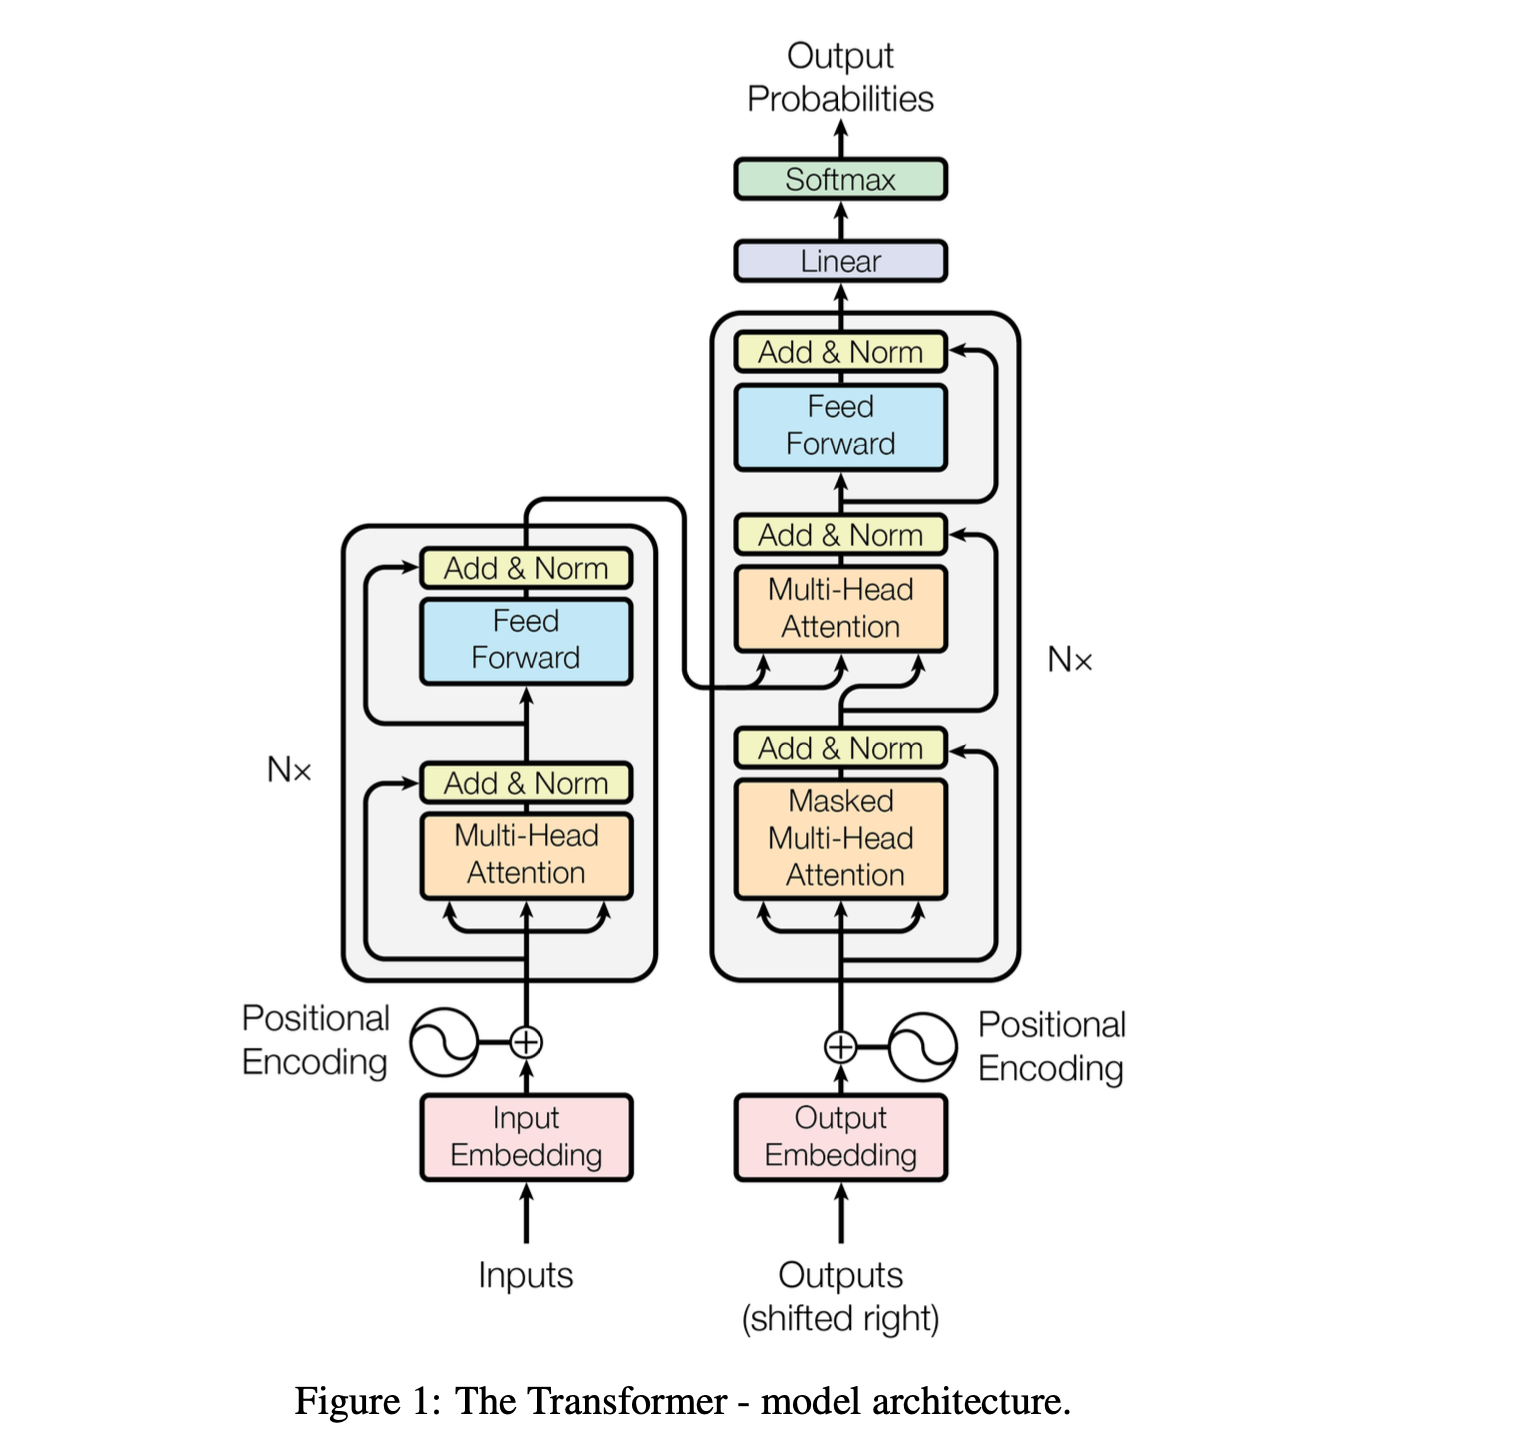

In [64]:
class Transformer(nn.Module):
  def __init__(self , encoder:Encoder , decoder:Decoder , src_embed:InputEmbeddings , tgt_embed:InputEmbeddings , src_pos:PositionalEncoding , tgt_pos:PositionalEncoding , projection_layer:ProjectionLayer) -> None:
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.src_pos = src_pos
    self.tgt_pos = tgt_pos
    self.projection_layer = projection_layer

  def encode(self , src , src_mask):
    src = self.src_embed(src)
    src = self.src_pos(src)
    return self.encoder(src , src_mask)

  def decode(self , encoder_output , src_mask , tgt , tgt_mask):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos(tgt)
    return self.decoder(tgt , encoder_output , src_mask , tgt_mask)

  def project(self , x):
    return self.projection_layer(x)



In [65]:
def build_transformer(src_vocab_size:int , tgt_vocab_size:int , src_seq_len:int , tgt_seq_len:int , d_model:int = 512 , N:int = 6 , h:int = 8 , dropout:float = 0.1 , d_ff:int = 2048) -> Transformer:

  src_embed = InputEmbeddings(d_model , src_vocab_size)
  tgt_embed = InputEmbeddings(d_model , tgt_vocab_size)

  src_pos = PositionalEncoding(d_model , src_seq_len , dropout)
  tgt_pos = PositionalEncoding(d_model , tgt_seq_len , dropout)

  encoder_blocks = []
  for _ in range(N):
    encoder_self_attention_block = MultiHeadAttentionBlock(d_model , h , dropout)
    feed_forward_block = FeedForwardBlock(d_model , d_ff , dropout)
    encoder_block = EncoderBlock(encoder_self_attention_block , feed_forward_block , dropout)
    encoder_blocks.append(encoder_block)

  decoder_blocks = []
  for _ in range(N):
    decoder_self_attention_block = MultiHeadAttentionBlock(d_model , h , dropout)
    decoder_cross_attention_block = MultiHeadAttentionBlock(d_model , h , dropout)
    feed_forward_block = FeedForwardBlock(d_model , d_ff , dropout)
    decoder_block = DecoderBlock(decoder_self_attention_block , decoder_cross_attention_block , feed_forward_block , dropout)
    decoder_blocks.append(decoder_block)

  encoder = Encoder(nn.ModuleList(encoder_blocks))
  decoder = Decoder(nn.ModuleList(decoder_blocks))

  projection_layer = ProjectionLayer(d_model , tgt_vocab_size)

  transformer = Transformer(encoder , decoder , src_embed , tgt_embed , src_pos , tgt_pos , projection_layer)

  for p in transformer.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return transformer


# Testing Transformer

# **Tokenization**

In [66]:

# Defining Tokenizer
def build_tokenizer(config, ds, lang):

    # Crating a file path for the tokenizer
    tokenizer_path = Path(config['tokenizer_file'].format(lang))

    # Checking if Tokenizer already exists
    if not Path.exists(tokenizer_path):

        # If it doesn't exist, we create a new one
        tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]')) # Initializing a new world-level tokenizer
        tokenizer.pre_tokenizer = Whitespace() # We will split the text into tokens based on whitespace

        # Creating a trainer for the new tokenizer
        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]",
                                                     "[SOS]", "[EOS]"], min_frequency = 2) # Defining Word Level strategy and special tokens

        # Training new tokenizer on sentences from the dataset and language specified
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
        tokenizer.save(str(tokenizer_path)) # Saving trained tokenizer to the file path specified at the beginning of the function
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path)) # If the tokenizer already exist, we load it
    return tokenizer # Returns the loaded tokenizer or the trained tokenizer


# **Loading Dataset**

In [67]:

# Iterating through dataset to extract the original sentence and its translation
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]

In [68]:
def get_ds(config):

    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary we will build later
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')

    # Building or loading tokenizer for both the source and target languages
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Splitting the dataset for training and validation
    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size]) # Randomly splitting the dataset

    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    # Creating dataloaders for the training and validadion sets
    # Dataloaders are used to iterate over the dataset in batches during training and validation
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True) # Batch size will be defined in the config dictionary
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt # Returning the DataLoader objects and tokenizers



# Casual Mask

In [69]:
def casual_mask(size):
  mask = torch.triu(torch.ones(1 , size , size) , diagonal = 1).type(torch.int)
  return mask == 0

In [70]:
class BilingualDataset(Dataset):

  def __init__(self , ds , tokenizer_src , tokenizer_tgt , src_lang , tgt_lang , seq_len) -> None:
    super().__init__()

    self.seq_len = seq_len
    self.ds = ds
    self.tokenizer_src = tokenizer_src
    self.tokenizer_tgt = tokenizer_tgt
    self.src_lang = src_lang
    self.tgt_lang = tgt_lang

    self.sos_token = torch.tensor([tokenizer_tgt.token_to_id('[SOS]')] , dtype = torch.int64)
    self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")] , dtype = torch.int64)
    self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")] , dtype = torch.int64)

  def __len__(self):
    return len(self.ds)

  def __getitem__(self , index:Any) -> Any:
    src_target_pair = self.ds[index]
    src_text = src_target_pair['translation'][self.src_lang]
    tgt_text = src_target_pair['translation'][self.tgt_lang]

    # Transform the text into tokens
    enc_input_tokens = self.tokenizer_src.encode(src_text).ids
    dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

    enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2
    dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

    if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
      raise ValueError("Sentence is too long")

    encoder_input = torch.cat(
        [
            self.sos_token,
            torch.tensor(enc_input_tokens , dtype = torch.int64) ,
            self.eos_token,
            torch.tensor([self.pad_token] * enc_num_padding_tokens , dtype = torch.int64)
        ]
    )

    decoder_input = torch.cat(
        [
            self.sos_token,
            torch.tensor(dec_input_tokens , dtype = torch.int64) ,
            torch.tensor([self.pad_token] * dec_num_padding_tokens , dtype = torch.int64)
        ]
    )

    label = torch.cat(
        [
            torch.tensor(dec_input_tokens , dtype = torch.int64) ,
            self.eos_token ,
            torch.tensor([self.pad_token] * dec_num_padding_tokens , dtype = torch.int64)
        ]
    )

    assert encoder_input.size(0) == self.seq_len
    assert decoder_input.size(0) == self.seq_len
    assert label.size(0) == self.seq_len

    return {
        'encoder_input': encoder_input ,
        'decoder_input': decoder_input ,
        'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() ,
        'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).int() & casual_mask(decoder_input.size(0)) ,
        'label': label ,
        'src_text': src_text ,
        'tgt_text': tgt_text
    }





# Validation Loop

In [71]:
def greedy_decode(model , source , source_mask , tokenizer_src , tokenizer_tgt , max_len , device):

  sos_idx = tokenizer_tgt.token_to_id('[SOS]')
  eos_idx = tokenizer_tgt.token_to_id('[EOS]')

  encoder_output = model.encode(source , source_mask)
  decoder_input = torch.empty(1 , 1).fill_(sos_idx).type_as(source).to(device)

  while True:
    if decoder_input.size(1) == max_len:
      break

    decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)

    out = model.decode(encoder_output , source_mask , decoder_input , decoder_input , decoder_mask)

    prob = model.project(out[: , -1])

    _ , next_word = torch.max(prob , dim = 1)
    decoder_input = torch.cat([decoder_input , torch.empty(1 , 1).type_as(source).fill_(next_word.item()).to(device)] , dim = 1)


    if next_word == eos_idx:
      break


  return decoder_input.squeeze(0)



In [72]:
def run_validation(model , validation_ds , tokenizer_src , tokenizer_tgt , max_len , device , print_msg , global_state , writer , num_examples = 2):
  model.eval()
  count = 0
  console_width = 80
  with torch.no_grad():
    for batch in validation_ds:
      count += 1
      encoder_input = batch['encoder_input'].to(device)
      encoder_mask = batch['encoder_mask'].to(device)

      assert encoder_input.size(0) == 1 , "Batch size must be 1 for validation"

      model_out = greedy_decode(model , encoder_input , encoder_mask , tokenizer_src , tokenizer_tgt , max_len , device)

      source_text = batch['src_text'][0]
      target_text = batch['tgt_text'][0]
      model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

      print_msg('_'*console_width)
      print_msg(f"SOURCE : {source_text}")
      print_msg(f"TARGET : {target_text}")

      if count == num_examples:
        break


# Training Loop

In [73]:
def get_model(config , vocab_src_len , vocab_tgt_len):
  model = build_transformer(vocab_src_len , vocab_tgt_len , config['seq_len'] , config['seq_len'] , config['d_model'])

  return model

In [74]:
def get_config():

  return {
      'batch_size': 8 ,
      'num_epochs': 20 ,
      'lr': 10**-4 ,
      'seq_len': 350 ,
      'd_model': 512 ,
      'lang_src': 'en' ,
      'lang_tgt': 'it' ,
      'model_folder': 'weights' ,
      'model_basename': 'tmodel_' ,
      'preload': None ,
      'tokenizer_file': 'tokenizer_{0}.json' ,
      'experiment_name': 'runs/tmodel'
  }


def get_weights_file_path(config , epoch:str):
  model_folder = config['model_folder']
  model_basename = config['model_basename']
  model_filename = f"{model_basename}{epoch}.pt"

  return str(Path('.') / model_folder / model_filename)

In [77]:
def train_model(config):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f"Using device {device}")

  Path(config['model_folder']).mkdir(parents = True , exist_ok = True)

  train_dataloader , val_dataloader , tokenizer_src , tokenizer_tgt = get_ds(config)

  model = get_model(config , tokenizer_src.get_vocab_size() , tokenizer_tgt.get_vocab_size()).to(device)

  writer = SummaryWriter(config['experiment_name'])

  optimizer = torch.optim.Adam(model.parameters() , lr = config['lr'] , eps = 1e-9)


  initial_epoch = 0
  global_step = 0

  if config['preload']:
    model_filename = get_weights_file_path(config , config['preload'])
    print(f"Preloading model {model_filename}")
    state = torch.load(model_filename)


    initial_epoch = state['epoch'] + 1
    optimizer.load_state_dict(state['optimizer_state_dict'])
    global_step = state['global_step']


  loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)

  for epoch in range(initial_epoch , config['num_epochs']):

    batch_iterator = tqdm(train_dataloader , desc = f"Processing Epoch {epoch:02d}")

    for batch in batch_iterator:
      model.train()

      encoder_input = batch['encoder_input'].to(device)
      decoder_input = batch['decoder_input'].to(device)
      encoder_mask = batch['encoder_mask'].to(device)
      decoder_mask = batch['decoder_mask'].to(device)

      encoder_output = model.encode(encoder_input , encoder_mask)
      decoder_output = model.decode(encoder_output , encoder_mask , decoder_input , decoder_mask)
      proj_output = model.project(decoder_output)

      label = batch['label'].to(device)

      loss = loss_fn(proj_output.view(-1 , tokenizer_tgt.get_vocab_size()) , label.view(-1))

      batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

      writer.add_scalar('train_loss' , loss.item() , global_step)
      writer.flush()

      loss.backward()

      optimizer.step()

      optimizer.zero_grad()

      global_step += 1

    run_validation(model , val_dataloader , tokenizer_src , tokenizer_tgt , config['seq_len'] , device , lambda msg:batch_iterator.write(msg) , global_step , writer)

    model_filename = get_weights_file_path(config , f"{epoch:02d}")

    torch.save({
        'epoch': epoch ,
        'model_state_dict': model.state_dict() ,
        'optimizer_state_dict': optimizer.state_dict() ,
        'global_step': global_step
    } , model_filename)

In [ ]:
if __name__ == "__main__":
  warnings.filterwarnings('ignore')
  config = get_config()
  train_model(config)